In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import pandas as pd

In [2]:
stims = np.array([[0,0,0],
         [0,0,1],
         [0,1,0],
         [0,1,1],
         [1,0,0],
         [1,0,1],
         [1,1,0],
         [1,1,1]], dtype=np.float32)

label_codes = {'A': [-1.0, 1.0], #A
               'B': [1.0, -1.0]} #B

def convert_labels(x):
    return [label_codes[i] for i in x]

labels_abs = [
    ['A','A','A','A','B','B','B','B'], # type 1
    ['A','A','B','B','B','B','A','A'], # type 2
    ['B','B','B','A','A','B','A','A'], # type 3
    ['B','B','B','A','B','A','A','A'], # type 4
    ['B','B','B','A','A','A','A','B'], # type 5
    ['B','A','A','B','A','B','B','A']  # type 6
]

labels = np.array(list(map(convert_labels, labels_abs)), dtype=np.float32)


class ALCOVE_RBF(keras.layers.Layer):

    def __init__(self, exemplars, c=6.5, **kwargs):
        super().__init__(**kwargs)
        self.exemplars = tf.dtypes.cast(exemplars, tf.float32)
        self.ne = exemplars.shape[0]
        self.ndims = exemplars.shape[1]
        self.c = c

    def get_attention(self):
        return self.attn.numpy()
    
    def build(self, input_shape):
        self.ndims = input_shape[-1]
        self.attn = tf.Variable(np.ones((self.ndims ,))/float(self.ndims), 
                                dtype=tf.float32, 
                                trainable=True,
                                constraint=tf.keras.constraints.NonNeg())

    def call(self, inputs):
        h_acts = []
        def activation(input_pat):
            return tf.math.exp(-self.c*tf.reduce_sum(self.attn*tf.math.abs(self.exemplars - input_pat),1))
        h_acts=tf.map_fn(lambda x: activation(x), inputs)
        output = tf.stack(h_acts)
        return output

# this is a custom call back whcih prints the value of the attention weights
print_attn = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_attention()))

PHI = 2.0
def categorization_accuracy(y_true, y_pred):
    probs = tf.keras.activations.softmax(PHI*y_pred)
    correct_ans = tf.argmax(y_true,axis=1)
    indx=tf.range(0,correct_ans.shape[0],1,dtype=tf.dtypes.int64)
    pred_probs = tf.gather_nd(probs, tf.stack([indx, correct_ans],1))
    return tf.reduce_mean(pred_probs)

## Run on one problem

Epoch 1/50
1/1 [==============================] - 1s 613ms/step - loss: 1.3218 - categorization_accuracy: 0.4487
[0.32289785 0.32289785 0.3437688 ]
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 1.1525 - categorization_accuracy: 0.5144
[0.32376066 0.32066533 0.33872345]
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 1.0433 - categorization_accuracy: 0.5535
[0.33032084 0.3242007  0.33070832]
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.9572 - categorization_accuracy: 0.5916
[0.3377768  0.33042488 0.32260635]
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.8824 - categorization_accuracy: 0.6247
[0.3449401 0.3372878 0.3150037]
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.8152 - categorization_accuracy: 0.6555
[0.35158184 0.34394777 0.30786288]
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.7540 - categorization_accuracy: 0.6838
[0.35773602 0.

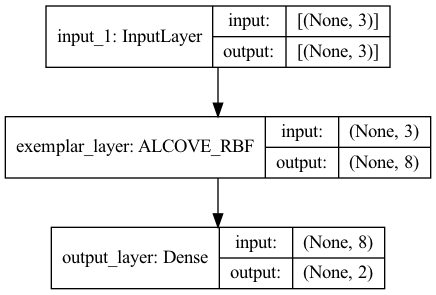

In [3]:
problem = 1
# model = keras.Sequential([
#     ALCOVE_RBF(stims),
#     layers.Dense(1, activation="sigmoid")
# ])
model = keras.Sequential(name="ALCOVE")
model.add(keras.Input(shape=(3,)))  ## this doesn't work but needs to for the multi optimizer to wrok
model.add(ALCOVE_RBF(stims, name="exemplar_layer"))
model.add(layers.Dense(2, name="output_layer"))
#model(stims[0:1])  # <-- needed because I can't figure out the symbolic shape 

optimizers = [
    tf.keras.optimizers.RMSprop(learning_rate=0.0033),  # different learning rate for first later
    tf.keras.optimizers.RMSprop(learning_rate=0.03) # than for the rest
]
optimizers_and_layers = [(optimizers[0], model.layers[0]), (optimizers[1], model.layers[1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

# change the loss!!
model.compile(optimizer=optimizer, loss=keras.losses.SquaredHinge(), metrics=[categorization_accuracy])
history = model.fit(stims, labels[problem], epochs=50, batch_size=8, verbose=True, callbacks=[print_attn])
run_df=pd.DataFrame(history.history)
run_df['error']=1.0-run_df['categorization_accuracy']
run_df['block']=run_df.index
run_df['problem']=problem+1

keras.utils.plot_model(model, show_shapes=True)

## Get learning curves for all problems

In [4]:
runs_df = []
for problem in range(labels.shape[0]):
    for i in range(10):
        model = keras.Sequential(name="ALCOVE")
        model.add(keras.Input(shape=(3,)))  ## this doesn't work but needs to for the multi optimizer to wrok
        model.add(ALCOVE_RBF(stims, name="exemplar_layer"))
        model.add(layers.Dense(2, name="output_layer"))

        optimizers = [
            tf.keras.optimizers.RMSprop(learning_rate=0.0033),  # different learning rate for first later
            tf.keras.optimizers.RMSprop(learning_rate=0.03) # than for the rest
        ]
        optimizers_and_layers = [(optimizers[0], model.layers[0]), (optimizers[1], model.layers[1])]
        optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

        model.compile(optimizer=optimizer, loss=keras.losses.SquaredHinge(), metrics=[categorization_accuracy])
        history = model.fit(stims, labels[problem], epochs=50, batch_size=8, verbose=True, callbacks=[print_attn])
        run_df=pd.DataFrame(history.history)
        run_df['error']=1.0-run_df['categorization_accuracy']
        run_df['block']=run_df.index
        run_df['run']=i
        run_df['problem']=problem+1
        runs_df.append(run_df)
runs_df = pd.concat(runs_df)

Epoch 1/50
1/1 [==============================] - 0s 421ms/step - loss: 1.4291 - categorization_accuracy: 0.4367
[0.32289785 0.34376884 0.34376884]
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 1.1868 - categorization_accuracy: 0.5234
[0.32471147 0.34218845 0.34707674]
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 1.0482 - categorization_accuracy: 0.5871
[0.33181632 0.33582464 0.346965  ]
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.9429 - categorization_accuracy: 0.6389
[0.33940876 0.3283905  0.34439552]
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.8551 - categorization_accuracy: 0.6829
[0.3464868  0.321081   0.34010184]
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.7787 - categorization_accuracy: 0.7210
[0.35296893 0.3141499  0.33481088]
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.7109 - categorization_accuracy: 0.7541
[0.35892257

<AxesSubplot:xlabel='block', ylabel='error'>

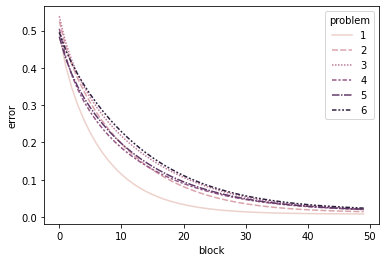

In [5]:
sns.lineplot(x='block',y='error',style='problem',hue='problem',data=runs_df.groupby(["block","problem"]).mean())